# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## 0. Problem Statement
For this Starbucks capstone project, I want to see what factors influence whether a customer completes the Buy One Get One Free (BOGO) offer. Some people might be incentivized after viewing the offer information; some might complete the offer due to certain characteristics other than the offer.

In [208]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1. Data Exploration & Visualization & Preprocessing

### 1.1. portfolio - containing offer ids and meta data about each offer (duration, type, etc.)

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [4]:
# There are 10 different offers
portfolio.shape

(10, 6)

Based on the bar chart **Average Difficulty by Offer Type**, we know informational offer type is the easiest offer since the minimum required spend to complete an offer is \\$0. On ther other hand, discount offer type on average requires roughly \\$11.75 to complete the offer.

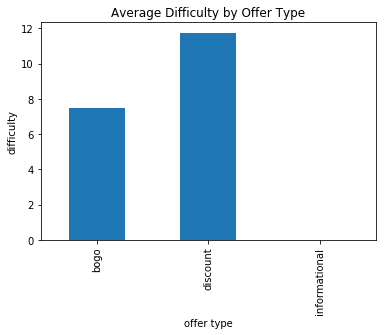

In [5]:
portfolio.groupby(['offer_type']).mean()['difficulty'].plot.bar()
plt.ylabel('difficulty')
plt.xlabel('offer type')
plt.title('Average Difficulty by Offer Type')
plt.show()

Based on the chart **Average Duration by Offer Type**, we know Starbucks usually runs discount offer type for a longer period (8.5 days) than others.

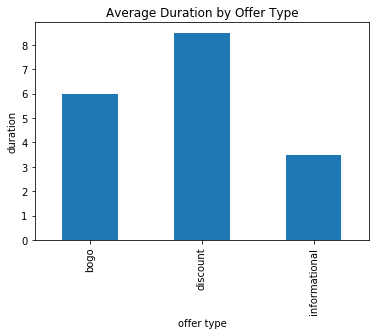

In [6]:
portfolio.groupby(['offer_type']).mean()['duration'].plot.bar()
plt.xlabel('offer type')
plt.ylabel('duration')
plt.title('Average Duration by Offer Type')
plt.show()

Based on the chart **Average Reward by Offer Type**, we know bogo offer type has the highest dollar amount rewards (\\$7.5) compared to others.

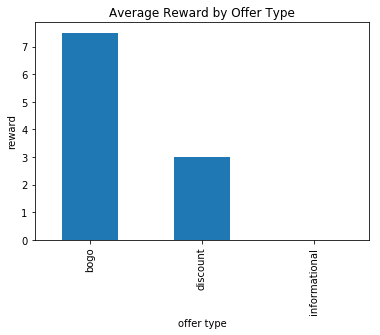

In [7]:
portfolio.groupby(['offer_type']).mean()['reward'].plot.bar()
plt.xlabel('offer type')
plt.ylabel('reward')
plt.title('Average Reward by Offer Type')
plt.show()

Note, for data preprocessing, we need to divide the list values in the **channels** column into separate columns as 4 dummy variables - email, mobile, social, and web.

In [8]:
# Convert list-like elements in channels column into 4 separate columns - email, mobile, social, and web.]
dummy_channels = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)

In [9]:
portfolio = pd.merge(portfolio, dummy_channels, left_index=True, right_index=True).drop(columns=['channels'])

In [10]:
portfolio

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [11]:
# Rename id to offer id for joining dataframes later
portfolio.rename(columns={'id':'offer id'}, inplace=True)

### 1.2. profile - demographic data for each customer

In [12]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
profile.shape

(17000, 5)

In [14]:
# Percentage of missing values across variables
profile.isnull().sum()/len(profile)

age                 0.000000
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.127941
dtype: float64

Based on the above summary, `gender` and `income` have the exact same percentage of missing values, which might indicate a group of people who don't want to share private information or simply errors in the database. To investigate further, I extracted the data points where `gender` is missing.

In [15]:
gender_missing = profile[profile['gender'].isnull()]

All `income` information are missing for data points where `gender` information are also unavailable.

In [16]:
gender_missing.isnull().sum()/len(gender_missing)

age                 0.0
became_member_on    0.0
gender              1.0
id                  0.0
income              1.0
dtype: float64

All data points with `gender` and `income` missing have `age` as 118, confirming these data points are erroneous user profile. Therefore, For data preprocessing, I'll drop any data points with `gender` and `income` as missing values.

In [17]:
gender_missing['age'].value_counts()

118    2175
Name: age, dtype: int64

In [18]:
# drop any data points with gender and income as missing values
profile.dropna(subset=['gender', 'age'], inplace=True)

In [19]:
# After dropping records with missing values, we have 14,825 customer profile left
len(profile['id'].unique())

14825

Note, column `became_member_on` is cast as data type int not datetime. Hence, we need to convert the data type.

In [20]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [21]:
# Convert became_member_on from int to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

According to **Customer Age Distribution** histogram, we can see that most of the customers' age ranges from 50 to 70 years old. 

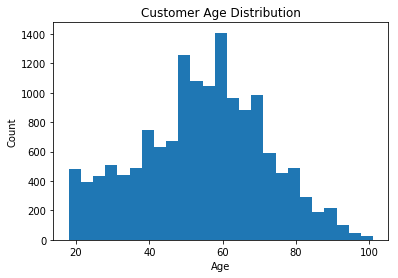

In [22]:
plt.hist(profile['age'], bins=25)
plt.title('Customer Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Breaking down the age distribution by gender, we can see that the age distribution across all gender are pretty similar. Although, for male customers, the people of age 20 to 30 are higher than other gender.

In [23]:
profile['gender'].unique()

array(['F', 'M', 'O'], dtype=object)

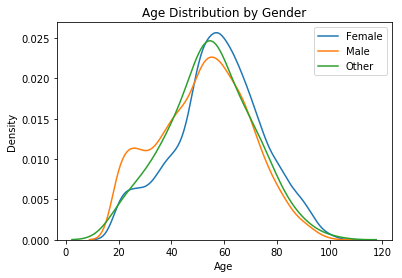

In [24]:
sns.kdeplot(profile[profile['gender'] == 'F']['age'], label = 'Female')
sns.kdeplot(profile[profile['gender'] == 'M']['age'], label = 'Male')
sns.kdeplot(profile[profile['gender'] == 'O']['age'], label = 'Other')
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution by Gender')
plt.show()

Based on **Customer Income Distribution** chart, we know that it's a right-skewed distribution, meaning the mean (\\$65,405) is greater than the median (\\$64,000). 

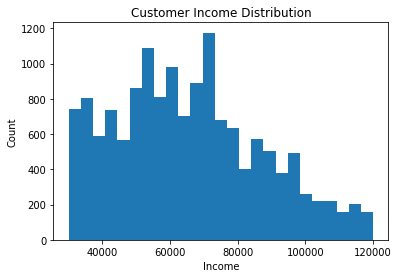

In [25]:
plt.hist(profile['income'], bins=25)
plt.title('Customer Income Distribution')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

In [26]:
print("Maximum income: ${:,.0f}".format(profile['income'].max()))
print("Minimum income: ${:,.0f}".format(profile['income'].min()))
print("Average income: ${:,.0f}".format(profile['income'].mean()))
print("Median income: ${:,.0f}".format(profile['income'].median()))

Maximum income: $120,000
Minimum income: $30,000
Average income: $65,405
Median income: $64,000


When breaking down the income distribution by gender, we can see that the income of female customers is relatively normal distributed. Most of the female customers have income range from \\$70k to \\$85k. As for male customers, their  income mostly concentrated between \\$50k and \\$80k. For other customers, their income mostly range from \\$55k to \\$70k. Also, there are more female customer with income more than \\$80k than male and other customers.

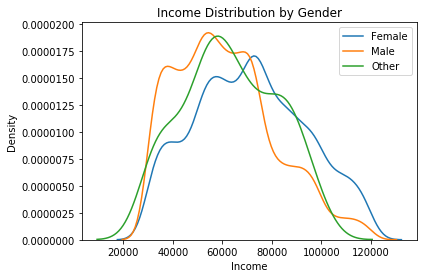

In [27]:
sns.kdeplot(profile[profile['gender'] == 'F']['income'], label = 'Female')
sns.kdeplot(profile[profile['gender'] == 'M']['income'], label = 'Male')
sns.kdeplot(profile[profile['gender'] == 'O']['income'], label = 'Other')
plt.xlabel('Income')
plt.ylabel('Density')
plt.title('Income Distribution by Gender')
plt.show()

In [28]:
profile.columns

Index(['age', 'became_member_on', 'gender', 'id', 'income'], dtype='object')

In [29]:
# Rename id to customer id for joining dataframes later
profile.rename(columns={'id':'customer id'}, inplace=True)

### 1.3. transcript - records for transactions, offers received, offers viewed, and offers completed

In [30]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [31]:
transcript.shape

(306534, 4)

In [32]:
# Rename person to customer id for joining dataframes later
transcript.rename(columns={'person':'customer id'}, inplace=True)

In [33]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

For data preprocessing, I'll split the dict value column `value` into separate columns - `offer id`, `reward`, and `amount`.

In [34]:
value_split = transcript['value'].apply(pd.Series)

After the splitting of column `value`, we can see that there are duplicated offer id columns - `offer id` and `offer_id`. To be consistent, I'm going to combine these 2 columns into `offer id`.

In [35]:
value_split.head(3)

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN


In [36]:
value_split.loc[((value_split['offer id'].isnull()) & 
                 (value_split['offer_id'].notnull())), 'offer id'] = value_split['offer_id']

In [37]:
value_split.drop(columns=['offer_id'], inplace=True)

In [38]:
transcript = pd.concat([transcript, value_split], axis=1).drop(columns=['value'])

### 1.4. Combine the 3 dataframes and perform further data preprocessing

In [59]:
df = pd.merge(transcript, portfolio, how='left', on='offer id')
df = pd.merge(df, profile, how='left', on='customer id')

In [61]:
df.head(3)

,event,customer id,time,offer id,amount,reward_x,difficulty,duration,offer_type,reward_y,email,mobile,social,web,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,75.0,2017-05-09,F,100000.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,NaN,NaT,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,68.0,2018-04-26,M,70000.0


Under the project scope, we only care about the people who completed or being provided the bogo offer. Therefore, I will filter for records with `offer_type` as **bogo**.

In [73]:
df_bogo = df[df['offer_type'] == 'bogo']

In [74]:
df_bogo.shape

(71617, 18)

In [75]:
df_bogo['event'].value_counts()

offer received     30499
offer viewed       25449
offer completed    15669
Name: event, dtype: int64

There are 4 scenarios we need to capture:
1. people who didnt view but completed the offer
2. people who viewed the offer and completed the offer
3. people who viewed the offer but didn't complete the offer
4. people who didn't view and didn't completed the offer

In [136]:
bogo_r = df_bogo[df_bogo['event'] == 'offer received'].reset_index(drop=True)
bogo_c = df_bogo[df_bogo['event'] == 'offer completed'].reset_index(drop=True)
bogo_v = df_bogo[df_bogo['event'] == 'offer viewed'].reset_index(drop=True)

In [137]:
# There are 984 customers who received the offer but didn't view the information
len(set(bogo_r['customer id'].unique()) - set(bogo_v['customer id'].unique()))

984

In [138]:
# There are 525 customers who didn't view the offer and didn't complete the offer
len(set(bogo_r['customer id'].unique()) - set(bogo_v['customer id'].unique()) - set(bogo_c['customer id'].unique()))

525

In [139]:
# There are 5,204 customers who viewed the offer information but never completed the offer
len(set(bogo_v['customer id'].unique()) - set(bogo_c['customer id'].unique()))

5204

In [140]:
# There are 459 customers who never viewed the offer information but completed the offer anyway
len(set(bogo_c['customer id'].unique()) - set(bogo_v['customer id'].unique()))

459

For people who completed the BOGO offers (scenario 1 & 2), we need to first figure out whether they viewed the offer or not.

In [141]:
bogo_c['offer_viewed'] = 0
viewed_customer_ids = list(bogo_v['customer id'].unique())
idx_to_remove_for_bogo_v = []
for i in range(len(bogo_c)):
    customer_id = bogo_c.iloc[i]['customer id']
    offer_id = bogo_c.iloc[i]['offer id']
    # Check whether the customer ever viewed any offers
    if customer_id in viewed_customer_ids:
        # Extract all offers viewed by the customer
        offer_ids_viewed = bogo_v[bogo_v['customer id'] == customer_id]['offer id'].values.tolist()
        # Check whether the customer viewed the offer
        if offer_id in offer_ids_viewed:
            bogo_c.loc[i, 'offer_viewed'] = 1
            idx_to_remove_for_bogo_v.extend(list(bogo_v[(bogo_v['customer id'] == customer_id) & (bogo_v['offer id'] == offer_id)].index))

In [142]:
bogo_c['offer_completed'] = 1

For people who viewed the offers, we need to figure out who didn't complete the offer (scenario 3).

In [146]:
# Remove duplicated index
idx_to_remove_for_bogo_v = list(set(idx_to_remove_for_bogo_v))

In [156]:
# Drop records the are already counted in bogo_c
bogo_v1 = bogo_v.drop(index=idx_to_remove_for_bogo_v)

In [172]:
# The rest of the records are people who viewed the offer but didn't complete the offer
bogo_v1['offer_viewed'] = 1
bogo_v1['offer_completed'] = 0

In [175]:
# combine bogo_c and bogo_v1
master_df = pd.concat([bogo_c, bogo_v1], axis=0)

In [182]:
# Double check we haven't include any records from scenario 4
(master_df['offer_viewed']+ master_df['offer_completed'] == 0).sum()

0

Finally, we need to know who didn't view and didn't complete the offer (scenario 4)

In [183]:
len(bogo_r)

30499

In [186]:
# bogo_r contains all customer ids from master df
set(master_df['customer id']) - set(bogo_r['customer id'])

set()

In [188]:
len(set(bogo_r['customer id']) - set(master_df['customer id']))

525

In [189]:
idx_to_remove_for_bogo_r = []
customer_ids_in_master_df = list(set(master_df['customer id']))
for i in range(len(bogo_r)):
    customer_id = bogo_r.iloc[i]['customer id']
    offer_id = bogo_r.iloc[i]['offer id']
    # Check whether the customer id is already in master_df
    if customer_id in customer_ids_in_master_df:
        # Extract all offer ids covered by master_df for this customer
        offer_ids_covered = master_df[master_df['customer id'] == customer_id]['offer id'].values.tolist()
        # Check whether the offer id is covered by one of the scenarios; if yes, we need to remove the record
        if offer_id in offer_ids_covered:
            idx_to_remove_for_bogo_r.append(i)

In [194]:
# Drop the scenarios (1,2,3) we already covered in master_df
bogo_r1 = bogo_r.drop(index=idx_to_remove_for_bogo_r)

In [195]:
# The rest of the records are people who didn't view and didn't complete the offer
bogo_r1['offer_viewed'] = 0
bogo_r1['offer_completed'] = 0

In [196]:
# combine master_df and bogo_r1
master_df = pd.concat([master_df, bogo_r1], axis=0)

Additional steps to conduct feature engineering and data cleaning.
> - remove unnecessary columns - 'event', 'customer id', 'offer id', 'reward_x', 'amount', 'offer_type'
> - rename column `reward_y` to `reward`
> - extract feature `membership_days` from `became_member_on`; then drop column `became_member_on`
> - convert gender into dummy variables - M, F, and O; ; then drop column `gender`
> - handle missing values; drop the records with missing values since they are from the same records

In [199]:
columns_to_remove = ['event', 'customer id', 'offer id', 'reward_x', 'amount', 'offer_type']

In [201]:
# remove unnecessary columns - 'event', 'customer id', 'offer id', 'reward_x', 'amount', 'offer_type'
master_df = master_df.drop(columns=columns_to_remove)

In [206]:
# rename column reward_y to rewar
master_df.rename(columns={'reward_y':'reward'}, inplace=True)

In [220]:
# extract feature membership_days from became_member_on; then drop column became_member_on
master_df['membership_days'] = (datetime.today() - master_df['became_member_on'])
master_df['membership_days'] = master_df['membership_days'].apply(lambda x: x.days)
master_df = master_df.drop(columns=['became_member_on'])

In [222]:
# convert gender into dummy variables - M, F, and O; then drop column gender
dummy_gender = pd.get_dummies(master_df['gender'].apply(pd.Series).stack()).sum(level=0)
master_df = pd.merge(master_df, dummy_gender, left_index=True, right_index=True).drop(columns=['gender'])

In [234]:
# handle missing values; drop the records with missing values since they are from the same records
master_df.isnull().sum()/len(master_df)

time               0.000000
difficulty         0.000000
duration           0.000000
reward             0.000000
email              0.000000
mobile             0.000000
social             0.000000
web                0.000000
age                0.083782
income             0.083782
offer_viewed       0.000000
offer_completed    0.000000
membership_days    0.083782
F                  0.000000
M                  0.000000
O                  0.000000
dtype: float64

In [235]:
master_df.dropna(subset=['age', 'income', 'membership_days'], inplace=True)

Before building the model, conduct a quick exploratory data analysis on the cleaned dataset.

1. Correlation analysis<br>
> - `reward` has strong positive relationship with `difficulty`
> - `offer_viewed` has relatively positive relationship with `social`
> - `social` has relatively positive relationship with `difficulty` and `reward` but relatively negative relationship with `duration`
> - `web` has relatively negative relationship with `difficulty`, `duration`, and `reward`
> - `M` has negative relationship with `F`

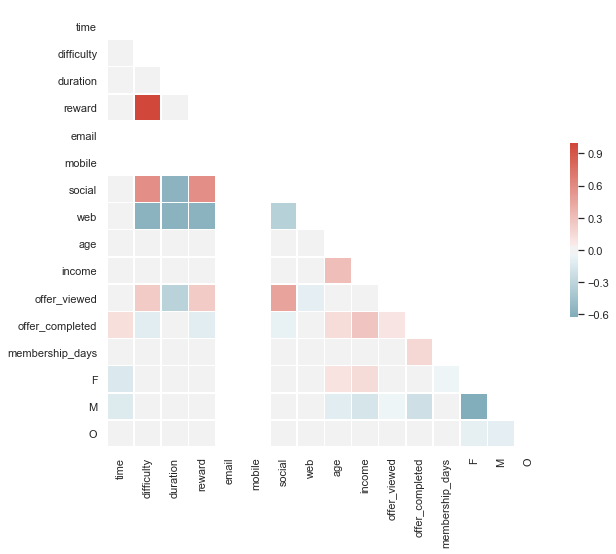

In [241]:
corr = master_df.corr()
sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 
f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(220, 15, as_cmap=True) 
sns.heatmap(corr, mask=mask, cmap= cmap, center=0,
            square=True, linewidths= 0.5, cbar_kws={"shrink": 0.4})
plt.show()

2. Income Distribution by whether the Customer Completed the Offer
> based on the density plot **Income Distribution by whether the Customer Completed the Offer**, we can see that people who completed the BOGO offer tend to have higher income than peopl who didn't. Most of the people who completed the offer have income range from \\$70k to \\$80k; other the other hand, people who didn't complete the offer have income range from \\$30k to \\$45k. Also, there are more people with income higher than \\$80k who completed the BOGO offer than people who didn't.

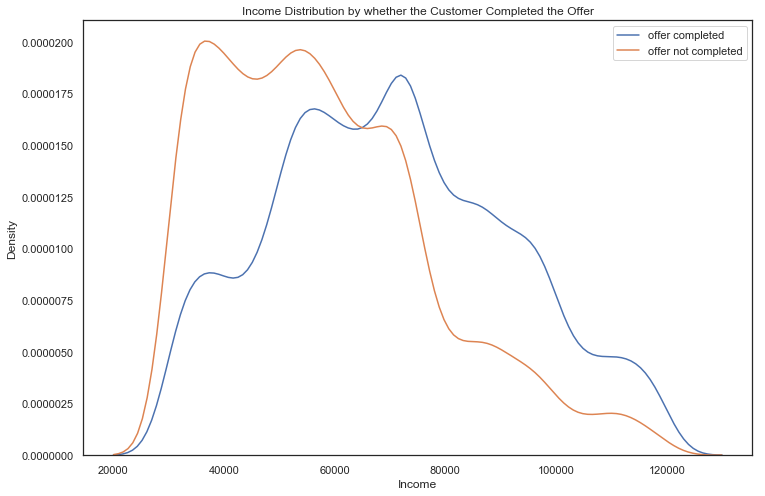

In [243]:
plt.figure(figsize = (12,8))
sns.kdeplot(master_df[master_df['offer_completed'] == 1]['income'], label = 'offer completed')
sns.kdeplot(master_df[master_df['offer_completed'] == 0]['income'], label = 'offer not completed')
plt.xlabel('Income')
plt.ylabel('Density')
plt.title('Income Distribution by whether the Customer Completed the Offer')
plt.show()

3.Customers completed BOGO vs. Customers who didn't complete BOGO
> From the bar chart, we know that there are more people who completed the BOGO offers (\~%60) than people who didn't (\~%40)

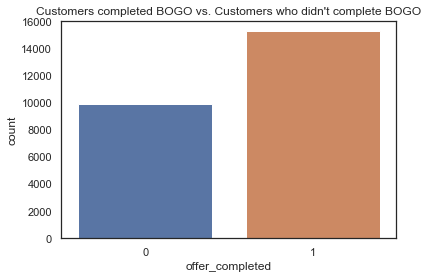

In [253]:
sns.countplot(master_df['offer_completed'])
plt.title('Customers completed BOGO vs. Customers who didn\'t complete BOGO')
plt.show()

Shuffle the rows, standardize the data, and conduct train test split for the dataset.

In [273]:
master_df = master_df.sample(frac=1).reset_index(drop=True)

In [274]:
feature_cols = list(master_df.columns)
feature_cols.remove('offer_completed')

In [275]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
y = master_df['offer_completed']
X = master_df[feature_cols]
scaler = MinMaxScaler() 
X_standardized = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## 2. Modeling

### 2.1. BernoulliNB

In [286]:
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_test)

In [287]:
error_nb = np.mean(pred_nb[:, np.newaxis] == np.array(y_test))
print(error_nb)

0.524694784897102


In [288]:
from sklearn.metrics import roc_auc_score
roc_auc_score(np.array(y_test), pred_nb)

0.6001624139460756

### 2.2 LogisticRegression

In [291]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [292]:
error_lr = np.mean(pred_lr[:, np.newaxis] == np.array(y_test))
print(error_lr)

0.5353552660087045


In [293]:
roc_auc_score(np.array(y_test), pred_lr)

0.6728467213249428

### 2.3 Neural Network

In [327]:
from keras import models
from keras import layers

nn = models.Sequential() 
nn.add(layers.Dense(15, input_dim=15, kernel_initializer='normal', activation='relu'))
nn.add(layers.Dense(12, kernel_initializer='normal', activation='relu'))
nn.add(layers.Dense(8, kernel_initializer='normal', activation='relu'))
nn.add(layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))
nn.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_42 (Dense)             (None, 12)                192       
_________________________________________________________________
dense_43 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 9         
Total params: 545
Trainable params: 545
Non-trainable params: 0
_________________________________________________________________


In [338]:
nn.fit(X_train, y_train,epochs=50, batch_size= 100)
test_loss, test_acc = nn.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/50
20148/20148 [==============================] - 0s 10us/step - loss: 0.4307 - acc: 0.7976
Epoch 2/50
20148/20148 [==============================] - 0s 9us/step - loss: 0.4304 - acc: 0.7979
Epoch 3/50
20148/20148 [==============================] - 0s 9us/step - loss: 0.4309 - acc: 0.7983
Epoch 4/50
20148/20148 [==============================] - 0s 9us/step - loss: 0.4305 - acc: 0.7978
Epoch 5/50
20148/20148 [==============================] - 0s 9us/step - loss: 0.4305 - acc: 0.7970
Epoch 6/50
20148/20148 [==============================] - 0s 9us/step - loss: 0.4302 - acc: 0.7970
Epoch 7/50
20148/20148 [==============================] - 0s 10us/step - loss: 0.4300 - acc: 0.7971
Epoch 8/50
20148/20148 [==============================] - 0s 10us/step - loss: 0.4305 - acc: 0.7975
Epoch 9/50
20148/20148 [==============================] - 0s 9us/step - loss: 0.4297 - acc: 0.7975
Epoch 10/50
20148/20148 [==============================] - 0s 10us/step - loss: 0.4304 - acc: 0.7968
Epoch

In [339]:
pred_nn = nn.predict(X_test)
roc_auc_score(y_test, pred_nn)

0.8688000920099239